In [1]:
from mylib import base, dataset
from mylib.model_classification import ModelClass
from mylib.model_base import ModelBase

from dotenv import dotenv_values
from pathlib import Path
from pprint import pprint, pformat
import zipfile

import opendatasets as od 
import pandas as pd
import pandas.api.types as pd_types

import numpy as np

import plotly.express as plotly_px

import joblib

import seaborn as sns
import matplotlib.pyplot as plt

import copy


In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50) # Устанавливаем максимальное количество отображаемых столбцов равным 50
#pd.set_option('display.max_rows', 50) # Устанавливаем максимальное количество отображаемых строк равным 20
pd.options.display.float_format = '{:.5f}'.format # Устанавливаем формат отображения чисел с двумя знаками после запятой
pd.options.mode.use_inf_as_na = True # Настройка режима Pandas для рассмотрения бесконечностей (inf) как пропущенных значений (NA)

# Конфигурация формата отображения графиков в виде векторных изображений
%config InlineBackend.figure_format = 'svg'

# для построения графиков внутри Jupyter Notebook
%matplotlib inline

# 1. Загрузка конфигов

In [3]:
# загрузить параметры
settings_dict = {
    **dotenv_values("settings")
}

settings = base.Settings(settings_dict)
settings.enviroment["RANDOM_STATE"] = int(settings.enviroment["RANDOM_STATE"])
n_jobs = -1
verbose = 1
load_from_kaggle = False

In [4]:
settings.enviroment

{'DATASET_SUBFOLDER': 'dataset',
 'RESULT_SUBFOLDER': 'result',
 'CACHE_SUBFOLDER': 'cached_results',
 'BOXPLOT_SUBFOLDER': 'boxplot',
 'RANDOM_STATE': 42,
 'DATASET_FILENAME_TEMPLATE': 'dataset_df_%s.joblib',
 'PARAMS_FILENAME_TEMPLATE': 'params_%s.joblib',
 'X_Train_FILENAME_TEMPLATE': 'X_Train_%s.joblib',
 'y_Train_FILENAME_TEMPLATE': 'y_Train_%s.joblib',
 'X_Test_FILENAME_TEMPLATE': 'X_Test_%s.joblib',
 'y_Test_FILENAME_TEMPLATE': 'y_Test_%s.joblib',
 'GRID_SEARCH_TEMPLATE_FILENAME': '03_GridSearch_%s.joblib',
 'MODEL_CLASS_TEMPLATE_FILENAME': '04_model_%s.joblib'}

# 1. Загрузка датасета

In [5]:
od.download_kaggle_dataset("https://www.kaggle.com/datasets/sooyoungher/smoking-drinking-dataset/data", 
                        Path(settings.enviroment["DATASET_SUBFOLDER"]))
dataset_df = pd.read_csv(Path(settings.enviroment["DATASET_SUBFOLDER"], "smoking-drinking-dataset", 'smoking_driking_dataset_Ver01.csv'))

Skipping, found downloaded files in "dataset/smoking-drinking-dataset" (use force=True to force download)


In [6]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991346 entries, 0 to 991345
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               991346 non-null  object 
 1   age               991346 non-null  int64  
 2   height            991346 non-null  int64  
 3   weight            991346 non-null  int64  
 4   waistline         991346 non-null  float64
 5   sight_left        991346 non-null  float64
 6   sight_right       991346 non-null  float64
 7   hear_left         991346 non-null  float64
 8   hear_right        991346 non-null  float64
 9   SBP               991346 non-null  float64
 10  DBP               991346 non-null  float64
 11  BLDS              991346 non-null  float64
 12  tot_chole         991346 non-null  float64
 13  HDL_chole         991346 non-null  float64
 14  LDL_chole         991346 non-null  float64
 15  triglyceride      991346 non-null  float64
 16  hemoglobin        99

In [7]:
# Датасет большой, обучение на некоторых моделях (в частности SVC) идет слишком долго. Для учебных целей это слишком.
# Возмем только часть датасета для ускорения обучения (для учебных целей считает слишком долго, т.к. датасет большой)
# Оставим только 5% от датасета
small_size = 0.05
dataset_df = dataset_df.sample(int(len(dataset_df) * small_size), random_state=settings.enviroment["RANDOM_STATE"])
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49567 entries, 676014 to 558135
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sex               49567 non-null  object 
 1   age               49567 non-null  int64  
 2   height            49567 non-null  int64  
 3   weight            49567 non-null  int64  
 4   waistline         49567 non-null  float64
 5   sight_left        49567 non-null  float64
 6   sight_right       49567 non-null  float64
 7   hear_left         49567 non-null  float64
 8   hear_right        49567 non-null  float64
 9   SBP               49567 non-null  float64
 10  DBP               49567 non-null  float64
 11  BLDS              49567 non-null  float64
 12  tot_chole         49567 non-null  float64
 13  HDL_chole         49567 non-null  float64
 14  LDL_chole         49567 non-null  float64
 15  triglyceride      49567 non-null  float64
 16  hemoglobin        49567 non-null  float

# 2. EDA датасета

## Обзор датасета

In [8]:
display(dataset_df.sample(7))

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
229413,Male,70,170,65,89.00000,0.40000,0.60000,1.00000,1.00000,140.00000,75.00000,114.00000,125.00000,35.00000,71.00000,95.00000,12.80000,1.00000,1.20000,29.00000,30.00000,21.00000,2.00000,Y
79195,Female,35,160,55,84.00000,1.00000,1.20000,1.00000,1.00000,119.00000,79.00000,94.00000,185.00000,76.00000,99.00000,50.00000,12.90000,1.00000,0.70000,23.00000,23.00000,10.00000,1.00000,N
244438,Female,25,165,50,65.00000,1.50000,1.50000,1.00000,1.00000,99.00000,80.00000,80.00000,133.00000,59.00000,56.00000,88.00000,14.70000,1.00000,0.80000,17.00000,12.00000,9.00000,1.00000,N
45651,Female,50,160,60,79.00000,0.60000,0.40000,1.00000,1.00000,95.00000,60.00000,101.00000,209.00000,68.00000,115.00000,130.00000,14.40000,1.00000,0.70000,17.00000,14.00000,15.00000,1.00000,N
315855,Female,30,160,65,77.00000,0.90000,1.00000,1.00000,1.00000,114.00000,69.00000,74.00000,180.00000,58.00000,106.00000,76.00000,14.20000,1.00000,0.50000,21.00000,20.00000,21.00000,1.00000,Y
557733,Female,60,145,50,77.00000,0.90000,1.00000,1.00000,1.00000,137.00000,64.00000,95.00000,180.00000,54.00000,92.00000,166.00000,13.40000,1.00000,0.50000,15.00000,13.00000,20.00000,1.00000,N
717088,Female,75,155,55,87.50000,9.90000,1.00000,1.00000,1.00000,115.00000,83.00000,84.00000,177.00000,48.00000,97.00000,158.00000,12.60000,1.00000,0.80000,24.00000,20.00000,18.00000,1.00000,N


In [9]:
display(dataset_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 49567 entries, 676014 to 558135
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sex               49567 non-null  object 
 1   age               49567 non-null  int64  
 2   height            49567 non-null  int64  
 3   weight            49567 non-null  int64  
 4   waistline         49567 non-null  float64
 5   sight_left        49567 non-null  float64
 6   sight_right       49567 non-null  float64
 7   hear_left         49567 non-null  float64
 8   hear_right        49567 non-null  float64
 9   SBP               49567 non-null  float64
 10  DBP               49567 non-null  float64
 11  BLDS              49567 non-null  float64
 12  tot_chole         49567 non-null  float64
 13  HDL_chole         49567 non-null  float64
 14  LDL_chole         49567 non-null  float64
 15  triglyceride      49567 non-null  float64
 16  hemoglobin        49567 non-null  float

None

In [10]:
display(dataset_df.describe())

,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd
count,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000
mean,47.70674,162.22456,63.21645,81.16106,0.98099,0.97858,1.03305,1.03192,122.38267,75.98687,100.58162,195.63157,56.93306,113.13703,132.13537,14.22419,1.09442,0.85953,25.92087,25.75433,37.08853,1.60048
std,14.18979,9.28602,12.51017,11.21569,0.62875,0.62473,0.17876,0.17578,14.50660,9.90704,24.68573,38.24389,15.32273,35.36320,101.42254,1.57799,0.43493,0.54653,17.12564,26.48746,49.48028,0.81394
min,20.00000,130.00000,30.00000,51.00000,0.10000,0.10000,1.00000,1.00000,75.00000,40.00000,40.00000,74.00000,5.00000,1.00000,7.00000,4.20000,1.00000,0.10000,1.00000,1.00000,3.00000,1.00000
25%,40.00000,155.00000,55.00000,74.00000,0.70000,0.70000,1.00000,1.00000,112.00000,70.00000,88.00000,170.00000,46.00000,89.00000,73.00000,13.20000,1.00000,0.70000,19.00000,15.00000,16.00000,1.00000
50%,45.00000,160.00000,60.00000,81.00000,1.00000,1.00000,1.00000,1.00000,120.00000,76.00000,96.00000,193.00000,55.00000,111.00000,106.00000,14.20000,1.00000,0.80000,23.00000,20.00000,23.00000,1.00000
75%,60.00000,170.00000,70.00000,87.30000,1.20000,1.20000,1.00000,1.00000,131.00000,82.00000,105.00000,219.00000,66.00000,135.00000,160.00000,15.40000,1.00000,1.00000,28.00000,29.00000,39.00000,2.00000
max,85.00000,190.00000,130.00000,999.00000,9.90000,9.90000,2.00000,2.00000,227.00000,150.00000,801.00000,897.00000,618.00000,1660.00000,3420.00000,22.70000,6.00000,98.00000,1377.00000,2535.00000,999.00000,3.00000


In [11]:
# Анализ пропусков
print("Доля пропусков в столбцах в %:")
nan_in_columns = dataset.nans_percents(dataset_df)
# список столбцов с пропусками
columns_with_nan = nan_in_columns[nan_in_columns > 0].index.to_list()
if len(columns_with_nan) > 0:
    print(f'Найдены пропущенные значения в столбцах\n{nan_in_columns[nan_in_columns > 0]}')
else:
    print('Нет столбцов с пропущенными значениями.')   

Доля пропусков в столбцах в %:
Нет столбцов с пропущенными значениями.


## Анализ столбцов

In [12]:
params = {}
# выделим числовые и категориальные переменные
params["target_column"] = "DRK_YN" # будем классифицировать по тому пьет человек или нет
# columns_X - все переменные датасета
params["columns_X"] = dataset_df.columns.to_list()
params["columns_X"].remove(params["target_column"])

In [13]:
print("Уникальные значения по столбцам")

nunique = dataset_df[params["columns_X"]].nunique()
for column in nunique.index:
    if nunique[column] <= 10:
        print(f'{column:20}: {nunique[column]:6} ({dataset_df.dtypes[column]}), {dataset_df[column].unique().tolist()}')
    else:
        print(f'{column:20}: {nunique[column]:6} ({dataset_df.dtypes[column]})')

Уникальные значения по столбцам
sex                 :      2 (object), ['Female', 'Male']
age                 :     14 (int64)
height              :     13 (int64)
weight              :     21 (int64)
waistline           :    542 (float64)
sight_left          :     21 (float64)
sight_right         :     23 (float64)
hear_left           :      2 (float64), [1.0, 2.0]
hear_right          :      2 (float64), [1.0, 2.0]
SBP                 :    121 (float64)
DBP                 :     91 (float64)
BLDS                :    309 (float64)
tot_chole           :    302 (float64)
HDL_chole           :    134 (float64)
LDL_chole           :    281 (float64)
triglyceride        :    772 (float64)
hemoglobin          :    149 (float64)
urine_protein       :      6 (float64), [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
serum_creatinine    :     65 (float64)
SGOT_AST            :    218 (float64)
SGOT_ALT            :    248 (float64)
gamma_GTP           :    465 (float64)
SMK_stat_type_cd    :      3 (float64), [

Датасет содержит столбцы, которые можно отнести к категориальным переменным:
  * sex, содержащий два строковых значения - Male и Female. Заменим значения на 0 и 1.
  * hear_left и hear_right, содержащие значения 1 (нормальный слух) и 2 (отклонения от нормы). Попробуем заменить на одно значение
  * SMK_stat_type_cd - признак того, курил/курит человек или нет. 3 значения - 1(никогда не курил), 2(курил, но бросил), 3(продолжаю курить). Оставим значения как есть.
  * urine_protein - тоже условно можно отнести к категориальным переменным ввиду небольшого количества конкретных значений.

In [14]:
# Категориальные столбцы
params["cat_columns"] = ["sex", "hear_left", "hear_right", "urine_protein", "SMK_stat_type_cd"]

# числовые столбцы
params["num_columns"] = copy.deepcopy(params["columns_X"])
for cat_column in params["cat_columns"]:
    params["num_columns"].remove(cat_column)

### Анализ столбца с целевой переменной

Будем классифицировать, употребляет ли человек алкоголь или нет, следовательно целевая переменная DRK_YN

In [15]:
plotly_px.bar(dataset_df[params["target_column"]].value_counts(normalize=True), 
              title="Доля вхождений классов в %",
              width=400, height=300)

Целевая переменная содержит два значения *Y* и *N*, примерно в одинаковом количестве (классы сбалансированные).
Необходимо заменить на числа. Заменим Y на 1, N на 0.

In [16]:
dataset_df["target2"] = 0
dataset_df.loc[dataset_df[params["target_column"]] == 'Y', "target2"] = 1
dataset_df.loc[dataset_df[params["target_column"]] == 'N', "target2"] = 0
dataset_df.drop([params["target_column"]], axis=1, inplace=True)
dataset_df.rename(columns={"target2": params["target_column"]}, inplace=True)

plotly_px.bar(dataset_df[params["target_column"]].value_counts(normalize=True), 
              title="Доля вхождений классов в %",
              width=400, height=300)

## Анализ и обработка категориальных столбцов

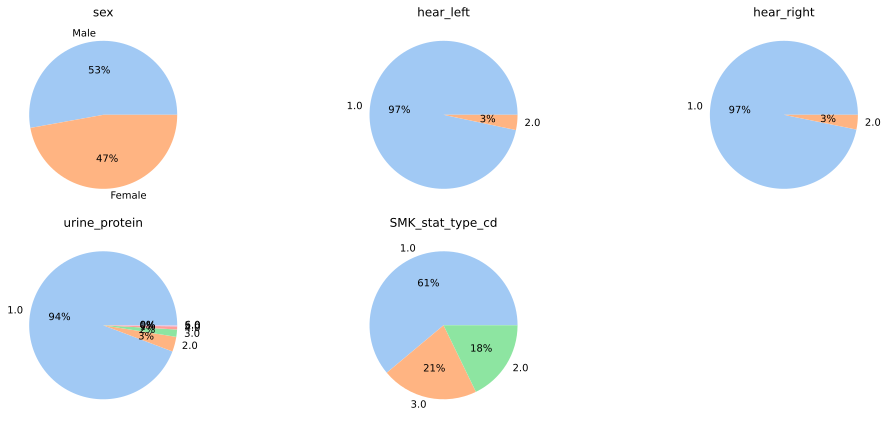

In [17]:
dataset.show_boxes_plt(dataset_df, params["cat_columns"], ncols = 3, type="pie")

Столбец *sex*:
  * примерно равномерное распределение значений Male и Female
  * решение: заменить значения на 1 (Male) и 0 (female)

Столбцы *hear_left* и *hear_right*:
  * примерно одинаковое распределение значений в обоих столбцах: 97% - нормальный слух, 3% - с отклонениями
  * решение: заменить на один столбец, который будет содержать объединенную информацию по обоим столбцам

Столбец *urine_protein*:
  * 94% строк содержат значение 1, 3% - 2, оставшиеся 3% - значения 3-6.
  * решение: оставить как есть

Столбец *SMK_stat_type_cd*:
  * 61% - значение 1(никогда не курил), оставшиеся значения примерно одинаково.
  * решение: оставить как есть

### Обработка столбца sex

In [18]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49567 entries, 676014 to 558135
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sex               49567 non-null  object 
 1   age               49567 non-null  int64  
 2   height            49567 non-null  int64  
 3   weight            49567 non-null  int64  
 4   waistline         49567 non-null  float64
 5   sight_left        49567 non-null  float64
 6   sight_right       49567 non-null  float64
 7   hear_left         49567 non-null  float64
 8   hear_right        49567 non-null  float64
 9   SBP               49567 non-null  float64
 10  DBP               49567 non-null  float64
 11  BLDS              49567 non-null  float64
 12  tot_chole         49567 non-null  float64
 13  HDL_chole         49567 non-null  float64
 14  LDL_chole         49567 non-null  float64
 15  triglyceride      49567 non-null  float64
 16  hemoglobin        49567 non-null  float

In [19]:
# обработка столбца sex
dataset_df["sex2"] = 0
dataset_df.loc[dataset_df["sex"] == 'Male',   "sex2"] = 1
dataset_df.loc[dataset_df["sex"] == 'Female', "sex2"] = 0
dataset_df.drop(["sex"], axis=1, inplace=True)
dataset_df.rename(columns={"sex2": "sex"}, inplace=True)
plotly_px.bar(dataset_df["sex"].value_counts(normalize=True), 
              title="Доля вхождений классов в %",
              width=400, height=300)

Примерно одинаковое количестов по обоим полам.

### Обработка столбцов hear_left и hear_right

In [20]:
# закодируем плохой слух (2) значением 0
dataset_df.loc[dataset_df["hear_left"] == 2, "hear_left"] = 0
dataset_df.loc[dataset_df["hear_right"] == 2, "hear_right"] = 0
# сформируем новый столбец, содержащий информацию о качесте слуха - как сумма качества слуха обоими ушами
dataset_df["hear"] = dataset_df["hear_left"] + dataset_df["hear_right"]
params["columns_X"].append("hear")
params["cat_columns"].append("hear")

# проверим результат
display(dataset_df[["hear_left", "hear_right", "hear"]].sample(10, random_state=35))

,hear_left,hear_right,hear
454483,1.00000,1.00000,2.00000
362490,1.00000,1.00000,2.00000
562339,1.00000,1.00000,2.00000
794745,1.00000,1.00000,2.00000
700297,1.00000,1.00000,2.00000
601755,1.00000,1.00000,2.00000
249874,1.00000,1.00000,2.00000
947041,1.00000,1.00000,2.00000
371348,1.00000,1.00000,2.00000
128870,1.00000,1.00000,2.00000


In [21]:
# Удалим лишние столбцы
#dataset_df.drop(["hear_left", "hear_right"], axis=1, inplace=True)
params["columns_X"].remove("hear_left")
params["columns_X"].remove("hear_right")
params["cat_columns"].remove("hear_left")
params["cat_columns"].remove("hear_right")

In [22]:
plotly_px.bar(dataset_df["hear"].value_counts(normalize=True), 
              title="Доля вхождений классов в %",
              width=400, height=300)

Подавляющее большинство (95.5%) обладают хорошим слухом, у 2.8% ослаблен слух на одно ухо.

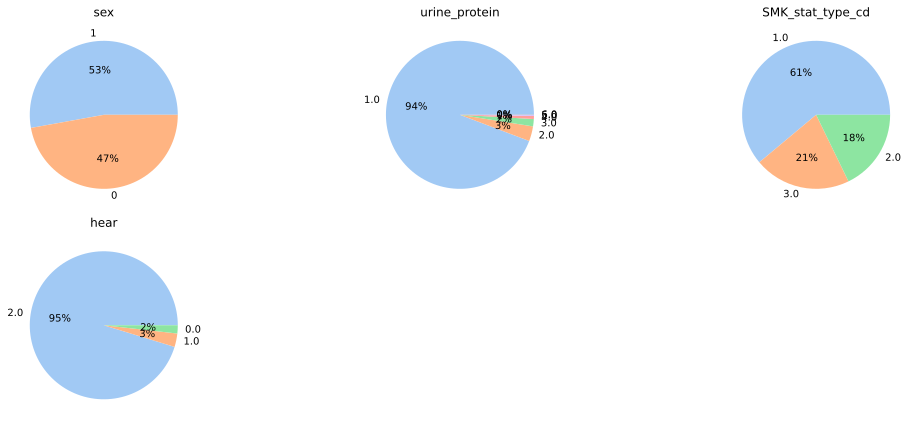

In [23]:
dataset.show_boxes_plt(dataset_df, params["cat_columns"], ncols = 3, type="pie")

## Анализ числовых столбцов

In [24]:
display(dataset_df[params["num_columns"]].describe())

,age,height,weight,waistline,sight_left,sight_right,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP
count,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000,49567.00000
mean,47.70674,162.22456,63.21645,81.16106,0.98099,0.97858,122.38267,75.98687,100.58162,195.63157,56.93306,113.13703,132.13537,14.22419,0.85953,25.92087,25.75433,37.08853
std,14.18979,9.28602,12.51017,11.21569,0.62875,0.62473,14.50660,9.90704,24.68573,38.24389,15.32273,35.36320,101.42254,1.57799,0.54653,17.12564,26.48746,49.48028
min,20.00000,130.00000,30.00000,51.00000,0.10000,0.10000,75.00000,40.00000,40.00000,74.00000,5.00000,1.00000,7.00000,4.20000,0.10000,1.00000,1.00000,3.00000
25%,40.00000,155.00000,55.00000,74.00000,0.70000,0.70000,112.00000,70.00000,88.00000,170.00000,46.00000,89.00000,73.00000,13.20000,0.70000,19.00000,15.00000,16.00000
50%,45.00000,160.00000,60.00000,81.00000,1.00000,1.00000,120.00000,76.00000,96.00000,193.00000,55.00000,111.00000,106.00000,14.20000,0.80000,23.00000,20.00000,23.00000
75%,60.00000,170.00000,70.00000,87.30000,1.20000,1.20000,131.00000,82.00000,105.00000,219.00000,66.00000,135.00000,160.00000,15.40000,1.00000,28.00000,29.00000,39.00000
max,85.00000,190.00000,130.00000,999.00000,9.90000,9.90000,227.00000,150.00000,801.00000,897.00000,618.00000,1660.00000,3420.00000,22.70000,98.00000,1377.00000,2535.00000,999.00000


В некоторых столбцах максимальные значения, предположительно, выходят за рамки адекватных значений. Возможно это признак того, что в это либо пропуски, либо какие-то спецзначения. Проверим эту гипотезу. Если это нормальное значение, то должны быть еще значения, близкие в максимальному.
Необходимо проверить столбцы:
 * waistline, 999
 * sight_left и sight_right, 9.9
 * SGOT_AST, 9999
 * gamma_GTP, 999

### Проверка максимальных значений некоторых свойств

In [25]:
def check_critical_values(dataset_df, col_name, critical_value):
    len_critical = len(dataset_df[dataset_df[col_name] >= critical_value])
    print(f'Строк с критичными значениями: {len_critical} из {len(dataset_df)} ({round(len_critical / len(dataset_df) * 100.0, 4)}%)')
    #print(f'Строк со значениями ниже критичного: {len(dataset_df[dataset_df[col_name] < critical_value])}')
    print(f'Описание столбца без строк с критичными значениями')
    display(dataset_df[dataset_df[col_name] < critical_value][col_name].describe())

#### waistline

In [26]:
check_critical_values(dataset_df, "waistline", 999)

Строк с критичными значениями: 2 из 49567 (0.004%)
Описание столбца без строк с критичными значениями


count   49565.00000
mean       81.12403
std         9.58133
min        51.00000
25%        74.00000
50%        81.00000
75%        87.30000
max       130.00000
Name: waistline, dtype: float64

Очевидно, что значение 999 для waistline - это какое-то спецзначение. Т.к. корректно интерпретировать его не можем - имеет смысл удалить строки с этим значением, в виду небольшого их количества.

In [27]:
dataset_df.drop(dataset_df[dataset_df['waistline'] >= 999].index, inplace=True)

In [28]:
check_critical_values(dataset_df, "waistline", 999)

Строк с критичными значениями: 0 из 49565 (0.0%)
Описание столбца без строк с критичными значениями


count   49565.00000
mean       81.12403
std         9.58133
min        51.00000
25%        74.00000
50%        81.00000
75%        87.30000
max       130.00000
Name: waistline, dtype: float64

#### sight_left и sight_right

In [29]:
check_critical_values(dataset_df, "sight_left", 9.9)

Строк с критичными значениями: 174 из 49565 (0.3511%)
Описание столбца без строк с критичными значениями


count   49391.00000
mean        0.94958
std         0.33986
min         0.10000
25%         0.70000
50%         1.00000
75%         1.20000
max         2.50000
Name: sight_left, dtype: float64

In [30]:
check_critical_values(dataset_df, "sight_left", 9.9)

Строк с критичными значениями: 174 из 49565 (0.3511%)
Описание столбца без строк с критичными значениями


count   49391.00000
mean        0.94958
std         0.33986
min         0.10000
25%         0.70000
50%         1.00000
75%         1.20000
max         2.50000
Name: sight_left, dtype: float64

По всей видимости, что значение 0.9 для этих столбцов - это какое-то спецзначение. Т.к. корректно интерпретировать его не можем - имеет смысл удалить строки с этим значением, в виду небольшого их количества.

In [31]:
dataset_df.drop(dataset_df[dataset_df['sight_left'] >= 9.9].index, inplace=True)
dataset_df.drop(dataset_df[dataset_df['sight_right'] >= 9.9].index, inplace=True)

In [32]:
check_critical_values(dataset_df, "sight_left", 9.9)

Строк с критичными значениями: 0 из 49254 (0.0%)
Описание столбца без строк с критичными значениями


count   49254.00000
mean        0.95010
std         0.33974
min         0.10000
25%         0.70000
50%         1.00000
75%         1.20000
max         2.50000
Name: sight_left, dtype: float64

In [33]:
check_critical_values(dataset_df, "sight_left", 9.9)

Строк с критичными значениями: 0 из 49254 (0.0%)
Описание столбца без строк с критичными значениями


count   49254.00000
mean        0.95010
std         0.33974
min         0.10000
25%         0.70000
50%         1.00000
75%         1.20000
max         2.50000
Name: sight_left, dtype: float64

#### SGOT_AST

In [34]:
check_critical_values(dataset_df, "SGOT_AST", 9999)

Строк с критичными значениями: 0 из 49254 (0.0%)
Описание столбца без строк с критичными значениями


count   49254.00000
mean       25.90797
std        17.01198
min         1.00000
25%        19.00000
50%        23.00000
75%        28.00000
max      1377.00000
Name: SGOT_AST, dtype: float64

Есть значения, близкие к максимальному значению. Посмотрим "ящик с усами".

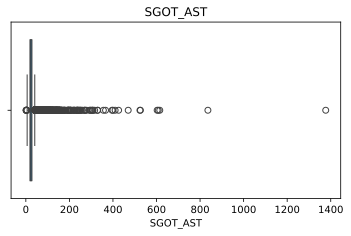

In [35]:
dataset.show_boxes_plt(dataset_df, ["SGOT_AST"], ncols = 1, type="box", row_height=200, total_width=400)

Возможно 9999 - это какое-то адекватное значение. Пока оставим это значение.

#### gamma_GTP

In [36]:
check_critical_values(dataset_df, "gamma_GTP", 999)

Строк с критичными значениями: 12 из 49254 (0.0244%)
Описание столбца без строк с критичными значениями


count   49242.00000
mean       36.79081
std        46.76929
min         3.00000
25%        16.00000
50%        23.00000
75%        39.00000
max       978.00000
Name: gamma_GTP, dtype: float64

Есть значения, близкие к максимальному значению. Посмотрим "ящик с усами".

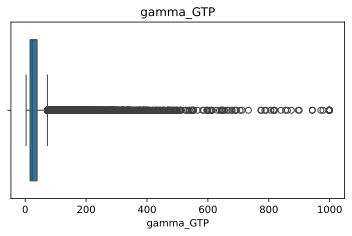

In [37]:
dataset.show_boxes_plt(dataset_df, ["gamma_GTP"], ncols = 1, type="box", row_height=200, total_width=400)

Возможно 9999 - это какое-то адекватное значение. Пока оставим это значение.

## Анализ корреляций

In [38]:
import plotly.express as px
fig = px.imshow(dataset_df[params["columns_X"]].corr(), height=900, width=900, text_auto='.2f' )
fig.show()

Есть высокая корреляция между:
  * столбцами tot_chole+HDL_chole и tot_chole+LDL_chole. Стоит избавиться от столбца tot_chole, 
    значение которого близко к сумме значений столбцов HDL_chole и LDL_chole.
  * столбцами SBP и DBP. Оставим SBP (верхнее, систолическое давление), а DBP (нижнее, диастолическое давление) заменим разницей SBP-DBP.
  * столбцами sex и height, heigh и weight, weight и waistlien. Что интуитивно ожидаемо, т.к. мужчины в среднем выше женщин. 
     Высокие - тяжелее низнких, а чем выше вес, тем толще талия. Заменим столбцы height, weight и waistline на %жира в организме, вычислив его по методу YMCA (https://planetcalc.com/184/)

In [39]:
# Уберем tot_chole
dataset_df.drop("tot_chole", axis=1, inplace=True)
params["columns_X"].remove("tot_chole")
params["num_columns"].remove("tot_chole")

# Заменим DBP на разницу между SBP и DBP
dataset_df["Diff_BP"] = dataset_df["SBP"] - dataset_df["DBP"]
params["columns_X"].append("Diff_BP")
params["num_columns"].append("Diff_BP")
params["columns_X"].remove("DBP")
params["num_columns"].remove("DBP")

In [40]:
def calc_fat_percent(row):
    if row["sex"] == 1:
        koef = -98.42
    else:
        koef = -76.76
                 
    return (koef + 4.15 * row["waistline"] * 0.3937007874 - 0.082 * row["weight"] * 2.2) / (row["weight"] * 2.2) * 100

# Сформируем столбец "% жира"
dataset_df["Percent_Fat"] = 0
dataset_df["Percent_Fat"] = dataset_df.apply(calc_fat_percent, axis=1)
params["columns_X"].append("Percent_Fat")
params["num_columns"].append("Percent_Fat")

params["columns_X"].remove("waistline")
params["num_columns"].remove("waistline")
params["columns_X"].remove("weight")
params["num_columns"].remove("weight")



In [41]:
fig = px.imshow(dataset_df[params["columns_X"]].corr(), height=900, width=900, text_auto='.2f' )
fig.show()

### Убираем выбросы с помощью IsolationForest

In [42]:
from sklearn.ensemble import IsolationForest

In [43]:
# Уберем целевой столбец из признаков
X = dataset_df[params["num_columns"]]
X.shape

(49254, 16)

In [44]:
iso = IsolationForest(
    n_estimators=100,
    contamination=0.05,  # допустим, считаем, что 5% наших объектов аномальные
    random_state=42
)
iso.fit(X)

IsolationForest(contamination=0.05, random_state=42)

In [45]:
preds = iso.predict(X)
preds

array([1, 1, 1, ..., 1, 1, 1])

In [46]:
anom_count = (preds == -1).sum()
total_count = len(preds)
print(f"Выбросы (анонмальные): {anom_count}")
print(f"Процент выбросов: {anom_count/total_count:.2%}")

Выбросы (анонмальные): 2463
Процент выбросов: 5.00%


In [47]:
dataset_df["anomaly"] = preds
dataset_df.head(20)

,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,BLDS,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN,sex,hear,Diff_BP,Percent_Fat,anomaly
676014,45,160,60,85.00000,1.20000,1.00000,1.00000,1.00000,113.00000,77.00000,84.00000,82.00000,100.00000,64.00000,13.30000,1.00000,0.80000,16.00000,13.00000,14.00000,1.00000,0,0,2.00000,36.00000,38.85906,1
958905,30,175,70,87.00000,0.90000,0.90000,1.00000,1.00000,135.00000,78.00000,90.00000,50.00000,147.00000,127.00000,15.90000,2.00000,1.20000,24.00000,28.00000,16.00000,1.00000,0,1,2.00000,57.00000,20.19329,1
472540,35,180,85,93.00000,1.20000,1.50000,1.00000,1.00000,129.00000,86.00000,102.00000,46.00000,119.00000,204.00000,16.60000,1.00000,1.00000,34.00000,61.00000,25.00000,2.00000,0,1,2.00000,43.00000,20.42504,1
244194,35,175,80,89.00000,1.50000,1.50000,1.00000,1.00000,119.00000,76.00000,77.00000,62.00000,130.00000,50.00000,15.20000,1.00000,0.90000,18.00000,17.00000,17.00000,1.00000,1,1,2.00000,43.00000,18.50079,1
88447,40,160,70,97.00000,1.50000,1.00000,1.00000,1.00000,124.00000,67.00000,78.00000,58.00000,91.00000,81.00000,12.80000,1.00000,0.50000,15.00000,17.00000,14.00000,1.00000,0,0,2.00000,57.00000,44.86770,1
719615,45,170,75,83.00000,1.50000,1.50000,1.00000,1.00000,120.00000,80.00000,71.00000,62.00000,135.00000,243.00000,14.70000,1.00000,0.70000,33.00000,31.00000,148.00000,1.00000,1,1,2.00000,40.00000,14.33954,1
626713,45,145,45,66.00000,0.70000,0.80000,1.00000,1.00000,100.00000,60.00000,88.00000,65.00000,78.00000,198.00000,13.80000,1.00000,0.80000,20.00000,26.00000,16.00000,1.00000,0,0,2.00000,40.00000,23.18853,1
223628,35,175,70,77.00000,1.00000,1.50000,1.00000,1.00000,116.00000,67.00000,94.00000,62.00000,125.00000,150.00000,14.20000,1.00000,0.80000,24.00000,34.00000,36.00000,2.00000,1,1,2.00000,49.00000,9.58382,1
410633,75,135,45,86.00000,0.50000,0.50000,1.00000,1.00000,130.00000,80.00000,95.00000,53.00000,103.00000,175.00000,11.80000,1.00000,0.90000,32.00000,20.00000,17.00000,1.00000,0,0,2.00000,50.00000,56.19577,1
72292,30,175,60,74.40000,1.50000,1.50000,1.00000,1.00000,118.00000,78.00000,95.00000,56.00000,109.00000,173.00000,14.70000,1.00000,0.60000,21.00000,17.00000,28.00000,1.00000,1,1,2.00000,40.00000,9.32959,1


In [48]:
df_clean_if = dataset_df[dataset_df["anomaly"] == 1].copy()
df_outliers_if = dataset_df[dataset_df["anomaly"] == -1].copy()

print("Исходная размерность:", dataset_df.shape)
print("Чистый набор без аномалий:", df_clean_if.shape)
print("Аномалии:", df_outliers_if.shape)

Исходная размерность: (49254, 27)
Чистый набор без аномалий: (46791, 27)
Аномалии: (2463, 27)


# Разделение на тренировочную и тестовую выборки

In [49]:
display(df_clean_if[params["columns_X"]].info())

<class 'pandas.core.frame.DataFrame'>
Index: 46791 entries, 676014 to 558135
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sex               46791 non-null  int64  
 1   age               46791 non-null  int64  
 2   height            46791 non-null  int64  
 3   sight_left        46791 non-null  float64
 4   sight_right       46791 non-null  float64
 5   SBP               46791 non-null  float64
 6   BLDS              46791 non-null  float64
 7   HDL_chole         46791 non-null  float64
 8   LDL_chole         46791 non-null  float64
 9   triglyceride      46791 non-null  float64
 10  hemoglobin        46791 non-null  float64
 11  urine_protein     46791 non-null  float64
 12  serum_creatinine  46791 non-null  float64
 13  SGOT_AST          46791 non-null  float64
 14  SGOT_ALT          46791 non-null  float64
 15  gamma_GTP         46791 non-null  float64
 16  SMK_stat_type_cd  46791 non-null  float

None

In [50]:
# сделаем два набора обучающих и тестовых выборок
X_train, X_test, y_train, y_test = dataset.prepare_dataset(df_clean_if, params, train_size=0.7)

In [51]:
print(np.mean(y_train), np.mean(y_test))


0.49595456904711016 0.49593959253454906


# Масштабирование выборок

In [52]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
scaler = StandardScaler()
X_train_StandardScaler = scaler.fit_transform(X_train)
X_test_StandardScaler = scaler.transform(X_test)    
X_train = np.array(X_train)
X_test = np.array(X_test)

# Сохранение промежуточных результатов

In [53]:
_ = joblib.dump(dataset_df, Path(settings.result_folder, settings.enviroment["DATASET_FILENAME_TEMPLATE"] % "dataset_df"), compress=3)
_ = joblib.dump(params,     Path(settings.result_folder, settings.enviroment["PARAMS_FILENAME_TEMPLATE"]  % "common"), compress=3)

_ = joblib.dump(df_clean_if, Path(settings.result_folder, settings.enviroment["DATASET_FILENAME_TEMPLATE"] % "df_clean_if"), compress=3)
_ = joblib.dump(params,      Path(settings.result_folder, settings.enviroment["PARAMS_FILENAME_TEMPLATE"]  % "df_clean_if"), compress=3)

_ = joblib.dump(y_train, Path(settings.result_folder, settings.enviroment["y_Train_FILENAME_TEMPLATE"] % "big"), compress=3)
_ = joblib.dump(y_test,  Path(settings.result_folder, settings.enviroment["y_Test_FILENAME_TEMPLATE"]  % "big"), compress=3)
_ = joblib.dump(X_train, Path(settings.result_folder, settings.enviroment["X_Train_FILENAME_TEMPLATE"] % "big"), compress=3)
_ = joblib.dump(X_test,  Path(settings.result_folder, settings.enviroment["X_Test_FILENAME_TEMPLATE"]  % "big"), compress=3)
_ = joblib.dump(X_train_StandardScaler, Path(settings.result_folder, settings.enviroment["X_Train_FILENAME_TEMPLATE"] % "big_StandardScaler,"), compress=3)
_ = joblib.dump(X_test_StandardScaler,  Path(settings.result_folder, settings.enviroment["X_Test_FILENAME_TEMPLATE"]  % "big_StandardScaler,"), compress=3)

In [54]:
print('Done.')

Done.
